In [1]:
%matplotlib inline
import torch
from torch import nn
from IPython import display
from matplotlib import pyplot as plt
from torch.utils import data
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
def use_svg_display():
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

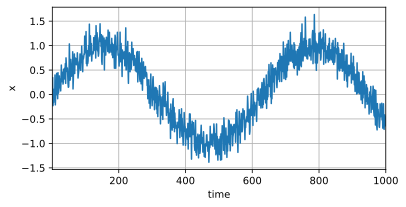

In [3]:
t = 1000
time = torch.arange(1, t + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (t,))
plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [4]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

tau = 4
features = torch.zeros((t - tau, tau))
for i in range(tau):
    features[:, i] = x[i : t-tau+i]
labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 600
train_iter = load_array((features[:n_train], labels[:n_train]),
                       batch_size, is_train=True)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = reshape(y, out.shape)
        l = loss(out, y)
        metric.add(reduce_sum(l), size(l))
    return metric[0] / metric[1]


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for x, y in train_iter:
            trainer.zero_grad()
            l = loss(net(x), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1},'
             f'loss: {evaluate_loss(net, train_iter, loss):f}')
        
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,loss: 0.056161
epoch 2,loss: 0.052815
epoch 3,loss: 0.053848
epoch 4,loss: 0.051227
epoch 5,loss: 0.049749


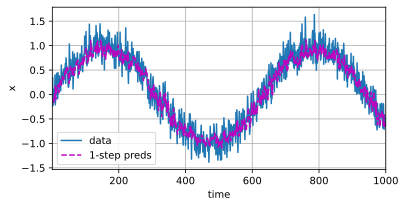

In [6]:
onestep_preds = net(features)
plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3)
    )

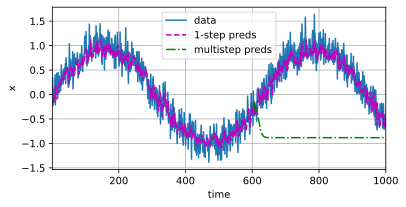

In [7]:
multistep_preds = torch.zeros(t)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, t):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

plot([time, time[tau:], time[n_train + tau:]], 
     [x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds','multistep preds'], 
     xlim=[1, 1000], figsize=(6, 3))

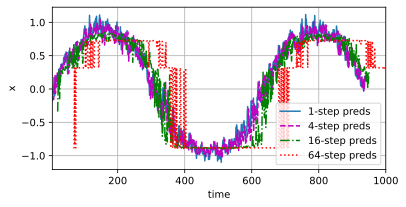

In [8]:
max_steps = 64
features = torch.zeros((t - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + t - tau - max_steps + 1]
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
steps = (1, 4, 16, 64)
plot([time[tau + i - 1:t -  max_steps + i] for i in steps],
    [features[:, (tau + i -1)].detach().numpy() for i in steps], 'time', 'x', 
    legend=[f'{i}-step preds' for i in steps],
    xlim=[5, 1000], figsize=(6, 3))